In [24]:
import os
import numpy as np
import scipy as sp
import pandas as pd
import networkx as nx
import matplotlib.pylab as plt
import time

%matplotlib inline

from urllib.request import urlopen
from pathlib import Path
from collections import defaultdict
from random import choice

## Carga de datos

In [48]:
red_lit = nx.read_edgelist('./Material_de_interes/tc02Data/yeast_LIT.txt')
red_apms = nx.read_edgelist('./Material_de_interes/tc02Data/yeast_AP-MS.txt')
red_bin = nx.read_edgelist('./Material_de_interes/tc02Data/yeast_Y2H.txt')

In [49]:
escenciales = open('./Datos/Essential_ORFs_paperHe2.txt')
lista_escenciales = []

for line in escenciales:
    lista_escenciales.append(line.rstrip('\n'))
    

In [50]:
def nodos_esenciales(red, lista_atr = lista_escenciales, atributo = 'Esencial'):
    
    dict_vacio = dict()
    nx.set_node_attributes(red, dict_vacio.fromkeys(list(red.nodes()),0), atributo )
    
    for nodo in lista_atr:
        try:
            red.nodes[nodo][atributo] = 1
        except KeyError:
            continue
            
    return None

In [51]:
nodos_esenciales(red_lit)
nodos_esenciales(red_bin)
nodos_esenciales(red_apms)

In [52]:
red_df = pd.read_csv('./Material_de_interes/tc02Data/yeast_LIT_Reguly.txt',sep="\t", header=0)

In [53]:
red_df.head()

,Bait gene/protein,Hit gene/protein,Bait Standard Name,Hit Standard Name,Experimental System,Source,PubMed ID
0,YBR236C,YML010W,ABD1,SPT5,Affinity Capture-MS,Lindstrom DL et al,12556496
1,YML010W,YBR236C,SPT5,ABD1,Affinity Capture-MS,Lindstrom DL et al,12556496
2,YDR448W,YPL254W,ADA2,HFI1,Affinity Capture-MS,Rodriguez-Navarro S et al,14718168
3,YDR448W,YDR176W,ADA2,NGG1,Affinity Capture-MS,Rodriguez-Navarro S et al,14718168
4,YDR448W,YOR257W,ADA2,CDC31,Affinity Capture-MS,Rodriguez-Navarro S et al,14718168


## B) Características de las redes

#### Tabla 1

In [54]:
import herramientas_redes as hr

In [55]:
redes = [red_apms, red_bin, red_lit]
props = []

for red in redes:
    props.append(hr.propiedades(red))
sRed = ['Red AP-MS','Red Y2H', 'Red Literatura']

In [10]:
pd.DataFrame(props, index=sRed).drop(['Densidad', 'Diámetro', 'Grado max', 'Grado min', 'Transitividad'], axis = 1)

,Clustering medio,Enlaces,Grado promedio,Nodos
Red AP-MS,0.554636,9070,11.183724,1622
Red Y2H,0.046194,2930,2.903865,2018
Red Literatura,0.292492,2925,3.808594,1536


#### Tabla 2

In [11]:
def overlap_enlaces(red1, red2):
    
    nodos = set(list(red1.nodes())+list(red2.nodes()))
    counter = 0
    for nodo in nodos:
        try:
            l1 = list(red1[nodo])
            l2 = list(red2[nodo])
            if l1 and l2:
                counter += len(hr.intersect(l1,l2))
        except KeyError:
            continue
    cantidad = counter/2
    
    return [ cantidad/ red1.number_of_edges(), cantidad/ red2.number_of_edges()]

In [12]:
lista_apms_lit = overlap_enlaces(red_apms, red_lit)
lista_lit_y2h = overlap_enlaces(red_lit,red_bin)
lista_y2h_apms = overlap_enlaces(red_bin,red_apms)

In [13]:
tabla = pd.DataFrame(np.nan, columns = sRed, index = sRed)
tabla.loc['Red AP-MS']['Red Y2H'] = lista_y2h_apms[1]
tabla.loc['Red Y2H']['Red AP-MS'] = lista_y2h_apms[0]
tabla.loc['Red AP-MS']['Red Literatura'] = lista_apms_lit[0]
tabla.loc['Red Literatura']['Red AP-MS'] = lista_apms_lit[1]
tabla.loc['Red Literatura']['Red Y2H'] = lista_lit_y2h[0]
tabla.loc['Red Y2H']['Red Literatura'] = lista_lit_y2h[1]
tabla.loc['Red Y2H']['Red Y2H'] = 1 #'Red Y2H'
tabla.loc['Red Literatura']['Red Literatura'] = 1 #'Red Literatura'
tabla.loc['Red AP-MS']['Red AP-MS'] = 1 #'Red AP-MS'

In [14]:
tabla

,Red AP-MS,Red Y2H,Red Literatura
Red AP-MS,1.000000,0.028666,0.143109
Red Y2H,0.088737,1.000000,0.087201
Red Literatura,0.443761,0.087350,1.000000


#### Tabla 3

In [15]:
redes = [red_lit, red_apms, red_bin]
sRed = ['Red Literatura', 'Red AP-MS', 'Red Y2H']
grados = [dict(),dict(),dict()]
x = [list,list,list]
y = [list,list,list]

for i in range(3):
    # Set ordenado de mayor a menor de los grados.
    degs = sorted(set(dict(redes[i].degree()).values()), reverse=True)
#     print(degs)
    # Diccionario con la data de los nodos, de donde se saca si son esenciales o no.
    esc = dict(redes[i].nodes(data=True))
#     print(esc)
    #nodos_grado = defaultdict(list)
    # Diccionario donde las keys son los grados y los values son dos números. El primero
    # está relacionado con la cantidad de nodos por grado, el segundo con la cantidad
    # de esenciales por grado.
    grados[i] = {d: [0,0] for d in degs}
    for nodo, deg in redes[i].degree():
        grados[i][deg][0] += 1
        # Suma uno si el nodo es esencial.
        grados[i][deg][1] += esc[nodo]['Esencial']
        #nodos_grado[deg].append(nodo)
#     print(grados)    

In [16]:
# Ahora cambia la lista de [nodos, esenciales] por [% de nodos, %esenciales], y va acumulando.
for i in range(3):
    n = redes[i].number_of_nodes()
    acumNodos = 0
    acumEsc = 0
    df = pd.DataFrame(grados[i]).T
    df.sort_index(axis=0, ascending=False, inplace=True)
    df.columns=['nodos','esenciales']
    for row in df.iterrows():
        acumNodos += row[1]['nodos']
        acumEsc += row[1]['esenciales']
        grados[i][row[0]][1] = acumEsc / acumNodos
        grados[i][row[0]][0] = acumNodos / n
    x[i],y[i] = zip(*list(grados[i].values()))

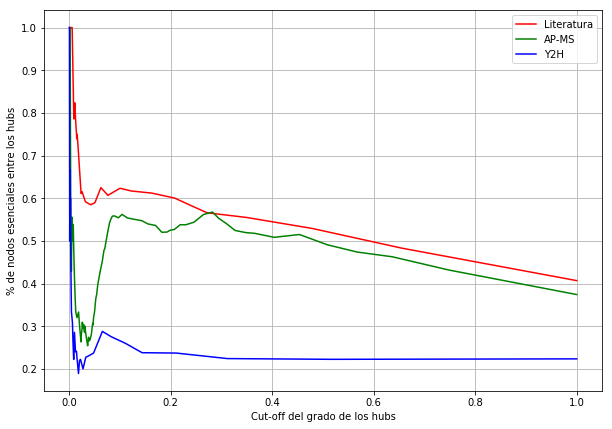

In [17]:
plt.figure(figsize=(10,7))
plt.plot(x[0],y[0],'r-', label='Literatura')
plt.plot(x[1],y[1],'g-', label='AP-MS')
plt.plot(x[2],y[2],'b-', label='Y2H')
plt.title('')
plt.xlabel('Cut-off del grado de los hubs')
plt.ylabel('% de nodos esenciales entre los hubs')
plt.legend()
plt.grid(True)

## C) Vulnerabilidad

In [18]:
def no_esenciales(red, esenciales = lista_escenciales):
    red_aux = red.copy()
    red_aux.remove_nodes_from(esenciales)
    return list(red_aux.nodes())

In [19]:
lista_no_esenciales = no_esenciales(red)

In [20]:
red = red_bin
  
medidas_centr = [ 'Random',
                 lambda x: nx.degree_centrality(x), 
                 lambda x: nx.eigenvector_centrality(x, tol = 200),
                 lambda x: nx.subgraph_centrality(x)]#,
#                  lambda x: nx.betweenness_centrality(x),
#                  lambda x: nx.current_flow_betweenness_centrality(x)]

nombres_med = [ 'Random', 'Degree Centrality','Eigen',
               'Subgraph']#,'Betweenness', 'Current flow']

fracciones = defaultdict()

In [59]:
# Falta corregir el punto de corte de la cantidad de iteraciones --> 700 alcanza
# Falta chequear porque random da tan raro a veces --> solucionado (creo), chequear
# Correr para las tres redes con todas las medidas --> falta todavia en la celda de arriba descomentarlas y correrlas 
#     que son las que mas demoran

def centralidad_letalidad(red, IT= 400, step = 4):
    
    # IT controla la cantidad total de nodos a eliminar
    # step controla de a cuantos nodos vamos eliminando solo para mejorar performance temporal
    
    for medida, nombre in zip(medidas_centr,nombres_med):

        red_size = red.number_of_nodes()
        GC = max(nx.connected_component_subgraphs(red), key=len)
        n = GC.number_of_nodes()
        fraccion = []
        i=0
        print(nombre)
        
        # Si la medida es Random la forma de eliminar nodos es diferente
        if medida == 'Random':
            print('Tiempo total de ejecución (segundos):')
            start = time.time()
            while i<IT:
                lista_no_esenciales = no_esenciales(GC)
                if lista_no_esenciales:
                    nodo = np.random.choice(lista_no_esenciales, min(len(lista_no_esenciales),step), replace = False)
                    GC.remove_nodes_from(nodo)
                    GC = max(nx.connected_component_subgraphs(GC), key = len)
                    fraccion.append(GC.number_of_nodes()/n)
                else:
                    fraccion.append(GC.number_of_nodes()/n)
                i+= step
            
            print(time.time()- start)
            fracciones[nombre] = fraccion

        else:
            print('Tiempo total de ejecución (segundos):')
            start = time.time()
            while i<IT:
                if GC.number_of_nodes() > 1:
                    centralidad = sorted(medida(GC).items(), key = lambda x: x[1])
                    GC.remove_nodes_from([nodo for nodo, cent in centralidad[-step:]])
                    if GC.number_of_nodes() != 0:    
                        GC = max(nx.connected_component_subgraphs(GC), key=len)

                fraccion.append(GC.number_of_nodes()/n)
                i+= step

            print(time.time()-start)
            fracciones[nombre] = fraccion
            
    return fracciones

# Algunas cosas a mejorar --> emprolijar codigo, agregar que también devuelva los porcentajes relativos de nodos que se
# van eliminando en cada paso, es decir que devuelva el x para plotear en la otra función en vez de que lo estime

In [28]:
def plot_centralidad_letalidad(red, fracciones, titulo, IT=400, step=4):

    plt.figure(figsize=(10,7))
    red_size = red.number_of_nodes()
    x = np.arange(0,1, step/red_size)[:np.int(IT/step)]
    #print(x.shape)
    for medida, porcentajes in zip(fracciones.keys(), fracciones.values()):
        y = np.array(porcentajes)
        #print(y.shape)
        plt.plot(x,y, label=medida)

    plt.title(titulo)    
    plt.xlabel('Porcentaje de nodos eliminados')
    plt.ylabel('Tamaño de la componente más grande')
    plt.legend()
    plt.grid(True)
    #plt.show()
    
    return None

Red AP-MS: 

Random
12.281466960906982
Degree Centrality
3.1478350162506104
Eigen
5.2106499671936035
Subgraph
22.737356185913086
1622 607 1004 325


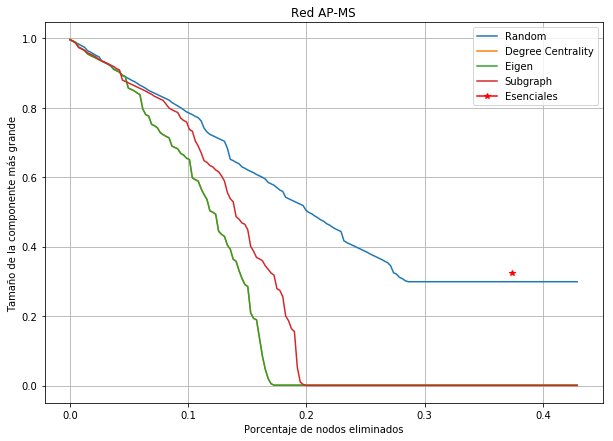

Red Y2H: 

Random
8.0409255027771
Degree Centrality
0.8317644596099854
Eigen
1.8817636966705322
Subgraph
23.25730562210083
2018 451 1647 1028


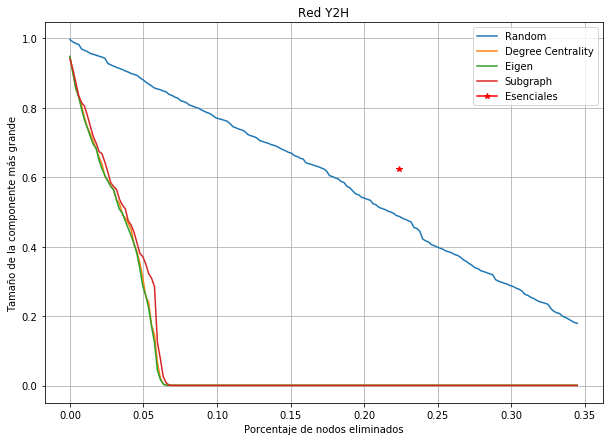

Red Literatura: 

Random
6.001083612442017
Degree Centrality
0.7414841651916504
Eigen
1.4482994079589844
Subgraph
14.030126094818115
1536 625 1213 341


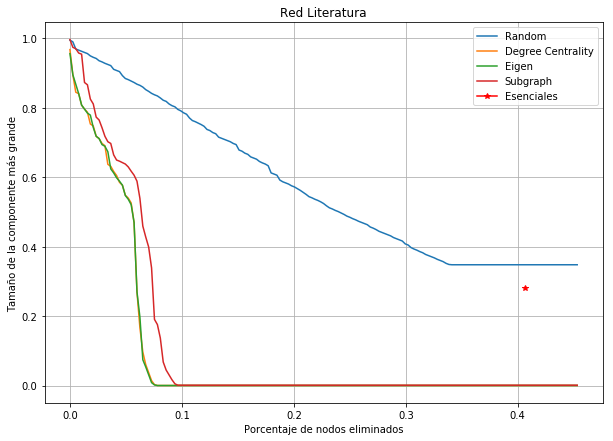

In [58]:
# Tabla de zotenko comparando la medida de centralidad con la vulnerabilidad
for red, nombre in zip(redes, sRed):
    
    print(nombre+': \n')
    it = 700 # Con esta cantidad por ahora parece ser suficiente para visualizar  
    
    frac = centralidad_letalidad(red, IT = it)
    plot_centralidad_letalidad(red, frac, nombre, IT = it)
    
    # Ploteamos que sucede al eliminar todos los nodos esenciales
    n = red.number_of_nodes()
    m = len(hr.intersect(list(red.nodes()),lista_escenciales))
    red_aux = red.copy()
    GC = max(nx.connected_component_subgraphs(red_aux), key = len)
    t = GC.number_of_nodes()
    red_aux.remove_nodes_from(lista_escenciales)
    GC2 = max(nx.connected_component_subgraphs(red_aux), key = len)
    
    plt.plot(m/n, GC2.number_of_nodes()/t, marker = '*', color = 'r', label = 'Esenciales')
    plt.legend()
    plt.show()